**Crawler**

In [12]:
# ------------------------------ #
# STEP 0: INSTALL DEPENDENCIES   #
# ------------------------------ #

# Install the external libraries into the current Google Colab runtime (so imports work)
!pip install requests beautifulsoup4  # installs: requests (HTTP) + beautifulsoup4 (HTML parsing)

# ------------------------------ #
# STEP 1: IMPORT LIBRARIES       #
# ------------------------------ #

# Import "requests" so the program can download web pages using HTTP GET (like a browser)
import requests  # used later: requests.get(url, timeout=...)

# Import "time" so we can pause between requests (helps avoid overloading the server)
import time  # used later: time.sleep(seconds)

# Import "json" so we can save and reload crawler progress (queue/visited/count) in a JSON file
import json  # used later: json.load(file) and json.dump(data, file)

# Import "os" so we can check whether files exist before reading/writing them
import os  # used later: os.path.exists(filename)

# Import "deque" which is an efficient queue for BFS (fast pop from the left, fast append to the right)
from collections import deque  # used later: queue.popleft() and queue.append()

# Import URL tools:
# - urljoin: converts relative links into absolute links using a base URL
# - urlparse: breaks a URL into scheme/domain/path/etc for filtering
from urllib.parse import urljoin, urlparse  # used later for link normalization + domain filtering

# Import BeautifulSoup so we can parse HTML and extract hyperlinks (<a href="...")
from bs4 import BeautifulSoup  # used later: BeautifulSoup(html, "html.parser")

# Import csv so we can write the output graph files (nodes.csv and edges.csv)
import csv  # used later: csv.writer(file).writerow(...)

# Import networkx (graph analysis library); not used in this crawler directly, but useful for later analysis
import networkx as nx  # (imported for later steps; crawler output is used to build a graph)

# ------------------------------ #
# STEP 2: CONFIGURATION SETTINGS #
# ------------------------------ #

# A list of seed pages where the crawler starts (initial frontier)
START_URLS = [  # the crawler will enqueue these first
    "https://ontariotechu.ca/",  # seed 1: Ontario Tech website root
    "https://uoit.ca/"           # seed 2: UOIT legacy domain root
]  # end of START_URLS list

# A set of allowed domains; crawler will only keep links whose domain matches one of these
ALLOWED_DOMAINS = {"ontariotechu.ca", "uoit.ca"}  # prevents the crawler from wandering off-site

# Maximum number of pages to crawl (hard stop for performance and assignment scope)
MAX_PAGES = 9000  # once pages_crawled reaches this, crawler stops even if queue still has URLs

# Timeout for each HTTP request (seconds); avoids hanging forever on slow/unresponsive pages
REQUEST_TIMEOUT = 10  # if server does not respond in 10 seconds, requests raises an exception

# Delay between requests (seconds); helps reduce load on servers and avoids rate-limiting
SLEEP_BETWEEN_REQUESTS = 0.3  # short pause after each page processed

# File used to store progress so crawl can resume after interruption (Colab restart/crash)
STATE_FILE = "crawler_state.json"  # stores: queue, visited, pages_crawled

# CSV output file storing directed edges (each hyperlink becomes source -> target)
EDGES_FILE = "edges.csv"  # used to build the directed web graph

# CSV output file storing nodes (each visited URL becomes one node)
NODES_FILE = "nodes.csv"  # list of all visited URLs

# Checkpoint frequency; every N pages we save state + update nodes file
CHECKPOINT_EVERY = 50  # reduces risk of losing progress on long crawls

# ------------------------------ #
# STEP 3: URL FILTERING FUNCTION #
# ------------------------------ #

# Function: decide whether a URL should be crawled (domain + scheme + file type filtering)
def is_allowed_url(url: str) -> bool:  # url is a string; returns True if allowed, False if not

    # Parse the URL into components (scheme, netloc/domain, path, query, fragment)
    parsed = urlparse(url)  # example: https://site.com/a/b -> scheme=https, netloc=site.com, path=/a/b

    # Reject links that are not normal web pages (e.g., mailto:, tel:, javascript:)
    if parsed.scheme not in ("http", "https"):  # only allow http/https protocols
        return False  # stop here: not crawlable as a standard webpage

    # Extract the domain (netloc) and normalize to lowercase for consistent comparison
    domain = parsed.netloc.lower()  # e.g., "ONTARIOTECHU.CA" becomes "ontariotechu.ca"

    # Keep only URLs whose domain ends with one of the allowed domains (handles subdomains too)
    if not any(domain.endswith(allowed) for allowed in ALLOWED_DOMAINS):  # checks each allowed domain
        return False  # reject off-site URLs like youtube.com, google.com, etc.

    # Define file extensions to skip because they are not HTML web pages (usually not useful for hyperlink graph)
    skip_exts = (  # tuple of extensions we do NOT want to crawl
        ".jpg", ".jpeg", ".png", ".gif", ".svg",  # image files
        ".pdf", ".mp4", ".mp3", ".avi", ".mov",   # documents + media files
        ".zip", ".rar", ".tar", ".gz", ".css", ".js"  # archives + stylesheets + scripts
    )  # end of skip_exts

    # If the URL path ends with any blocked extension, skip it (prevents downloading large/binary files)
    if any(parsed.path.lower().endswith(ext) for ext in skip_exts):  # checks file ending in path
        return False  # reject non-HTML resources

    # If all checks passed, the URL is acceptable for crawling
    return True  # allowed URL

# ------------------------------ #
# STEP 4: RESUME / STATE LOADING #
# ------------------------------ #

# Function: load crawler state so crawl can resume, or create a fresh start state if no file exists
def load_state():  # returns: queue, visited, pages_crawled

    # Check if the state file exists on disk; if yes we resume from saved progress
    if os.path.exists(STATE_FILE):  # True if crawler_state.json already exists

        # Open the state file in read mode using UTF-8 encoding (safe for URLs)
        with open(STATE_FILE, "r", encoding="utf-8") as f:  # f is the file handle

            # Read JSON contents and convert them into a Python dictionary
            data = json.load(f)  # data now has keys: "queue", "visited", "pages_crawled"

        # Rebuild BFS queue from saved list of URLs (deque is used for efficient popleft)
        queue = deque(data["queue"])  # restore the crawl frontier

        # Rebuild visited structure as a set for fast membership checks (O(1) average)
        visited = set(data["visited"])  # restore already processed pages

        # Restore how many pages were already crawled so we continue counting correctly
        pages_crawled = data["pages_crawled"]  # restore counter

        # Print a message so user knows the crawl resumed successfully
        print(f"[RESUME] Loaded state: {pages_crawled} pages crawled, {len(queue)} in queue.")  # progress info

    else:
        # If state file does not exist, we start a brand-new crawl

        # Initialize queue with the seed URLs
        queue = deque(START_URLS)  # frontier starts from START_URLS

        # Initialize empty visited set (no pages processed yet)
        visited = set()  # start empty

        # Initialize page counter to zero
        pages_crawled = 0  # start counting from 0

        # Print a message so user knows it’s a fresh crawl
        print("[START] Fresh crawl.")  # status info

    # Return these three objects to the caller (main crawl function)
    return queue, visited, pages_crawled  # output state

# ------------------------------ #
# STEP 5: SAVE STATE / CHECKPOINT #
# ------------------------------ #

# Function: save current crawler progress so it can be resumed later
def save_state(queue, visited, pages_crawled):  # inputs are current queue, visited set, and page count

    # Prepare a JSON-serializable dictionary; JSON cannot store deque/set directly
    data = {  # create dictionary to dump into JSON
        "queue": list(queue),  # convert deque -> list so JSON can store it
        "visited": list(visited),  # convert set -> list so JSON can store it
        "pages_crawled": pages_crawled,  # store integer counter
    }  # end of data dict

    # Open state file in write mode (overwrites old state with new state)
    with open(STATE_FILE, "w", encoding="utf-8") as f:  # open file for saving

        # Write the state dictionary to file in JSON format
        json.dump(data, f)  # persist progress

    # Print confirmation so user knows checkpoint occurred
    print(f"[CHECKPOINT] Saved state at {pages_crawled} pages.")  # checkpoint info

# ------------------------------ #
# STEP 6: INITIALIZE OUTPUT FILES #
# ------------------------------ #

# Function: create edges.csv and nodes.csv with headers if they don't exist yet
def init_files():  # no input; creates files if missing

    # If the edges file does not exist, create it and write the header row
    if not os.path.exists(EDGES_FILE):  # check if edges.csv exists

        # Open edges.csv in write mode; newline="" avoids blank lines on some systems
        with open(EDGES_FILE, "w", newline="", encoding="utf-8") as f:  # create file

            # Create a CSV writer object to write rows
            writer = csv.writer(f)  # CSV writer

            # Write header row (source URL, target URL)
            writer.writerow(["source", "target"])  # column names

    # If the nodes file does not exist, create it and write the header row
    if not os.path.exists(NODES_FILE):  # check if nodes.csv exists

        # Open nodes.csv in write mode
        with open(NODES_FILE, "w", newline="", encoding="utf-8") as f:  # create file

            # Create a CSV writer object
            writer = csv.writer(f)  # CSV writer

            # Write header row for nodes file (id column holds the URL)
            writer.writerow(["id"])  # column name

# ------------------------------ #
# STEP 7: WRITE EDGES TO CSV      #
# ------------------------------ #

# Function: append hyperlink edges (source -> targets) into edges.csv
def append_edges(source_url, target_urls):  # source_url is one page; target_urls is set/list of outgoing links

    # Open edges file in append mode so we add new edges without deleting old ones
    with open(EDGES_FILE, "a", newline="", encoding="utf-8") as f:  # append edges

        # Create CSV writer for the open file
        writer = csv.writer(f)  # CSV writer

        # Loop through each target URL found on the page
        for t in target_urls:  # each t is one outgoing link

            # Write one directed edge row: source -> target
            writer.writerow([source_url, t])  # store hyperlink relationship

# ------------------------------ #
# STEP 8: WRITE NODES TO CSV      #
# ------------------------------ #

# Function: write the full visited set into nodes.csv (overwrites file each time)
def append_nodes(visited):  # visited is a set of URLs that have been processed

    # Open nodes file in write mode (this replaces the old file with a fresh full list)
    with open(NODES_FILE, "w", newline="", encoding="utf-8") as f:  # overwrite nodes.csv

        # Create CSV writer
        writer = csv.writer(f)  # CSV writer

        # Write header
        writer.writerow(["id"])  # node ID column

        # Write each visited URL as a node row
        for node in visited:  # iterate through visited URLs

            # Write one node row containing the URL
            writer.writerow([node])  # save URL as node id

# ------------------------------ #
# STEP 9: FETCH A WEB PAGE        #
# ------------------------------ #

# Function: download a URL and return its HTML text (or None if not valid HTML)
def fetch_page(url: str):  # takes URL string; returns HTML string or None

    try:
        # Attempt to download the page using HTTP GET, with a timeout
        resp = requests.get(url, timeout=REQUEST_TIMEOUT)  # resp is the HTTP response object

    except Exception as e:
        # If request fails (timeout, connection error, etc.), print error and skip
        print(f"[ERROR] {url}: {e}")  # show which URL failed and why
        return None  # indicate fetch failure

    # If Content-Type does not look like HTML, skip (avoids binary downloads)
    if "text/html" not in resp.headers.get("Content-Type", "").lower():  # check response type
        return None  # not an HTML page

    # If server response status is not 200 OK, skip (e.g., 404 not found, 500 error)
    if resp.status_code != 200:  # status code check
        return None  # page not successfully retrieved

    # Return the HTML body as a string so we can parse it for links
    return resp.text  # raw HTML content

# ------------------------------ #
# STEP 10: EXTRACT LINKS FROM HTML#
# ------------------------------ #

# Function: parse HTML and collect all allowed outgoing links from a page
def extract_links(base_url: str, html: str):  # base_url is current page; html is its HTML content

    # Parse the HTML into a BeautifulSoup object (so we can search tags easily)
    soup = BeautifulSoup(html, "html.parser")  # creates HTML parse tree

    # Use a set to store links to automatically remove duplicates
    links = set()  # unique outgoing links

    # Find all <a> tags that have an href attribute (hyperlinks)
    for a in soup.find_all("a", href=True):  # iterate over clickable links

        # Get the href text from the tag and remove extra spaces
        href = a["href"].strip()  # raw link value

        # Turn relative links into absolute URLs using the current page as base
        abs_url = urljoin(base_url, href)  # ensures full URL (https://...)

        # Parse absolute URL so we can remove fragments and filter properly
        parsed = urlparse(abs_url)  # break it into parts

        # Remove fragment (#something) so same page sections don’t create duplicates
        abs_url = parsed._replace(fragment="").geturl()  # rebuild URL without #fragment

        # If URL passes domain/scheme/file filters, keep it
        if is_allowed_url(abs_url):  # call filter function
            links.add(abs_url)  # add to set of outgoing links

    # Return the set of unique outgoing links found on that page
    return links  # outgoing hyperlink targets

# ------------------------------ #
# STEP 11: BFS CRAWLING LOOP      #
# ------------------------------ #

# Function: run the BFS crawl, producing edges.csv and nodes.csv, with resume checkpoints
def bfs_crawl():  # no inputs; uses global CONFIG values

    # Load saved crawl state (resume) or initialize fresh state
    queue, visited, pages_crawled = load_state()  # queue=frontier, visited=done, pages_crawled=count

    # Ensure output CSV files exist and have headers
    init_files()  # creates edges.csv and nodes.csv if missing

    # Continue while there are URLs to process AND we have not hit the max page limit
    while queue and pages_crawled < MAX_PAGES:  # main crawl loop condition

        # Pop the next URL from the queue (FIFO order = BFS)
        current_url = queue.popleft()  # get next page to crawl

        # If we already crawled this URL, skip it to avoid repeated work
        if current_url in visited:  # visited membership check
            continue  # jump to next loop iteration

        # Print status line showing progress and which URL we are crawling now
        print(f"[CRAWL] ({pages_crawled + 1}/{MAX_PAGES}) {current_url}")  # progress output

        # Download the HTML content of the current page
        html = fetch_page(current_url)  # returns HTML string or None

        # If fetching failed or it was not HTML, mark visited and skip extraction
        if html is None:  # fetch failure check
            visited.add(current_url)  # treat as processed so we don’t retry forever
            continue  # go to next URL

        # Extract all outgoing links from the HTML of this page
        outgoing_links = extract_links(current_url, html)  # returns set of target URLs

        # Append edges (current_url -> each outgoing link) to edges.csv
        append_edges(current_url, outgoing_links)  # record directed hyperlinks

        # For each outgoing link, if not visited, add it to queue to crawl later
        for link in outgoing_links:  # iterate target URLs
            if link not in visited:  # only queue unseen pages
                queue.append(link)  # add to BFS queue

        # Mark current page as visited after processing its links
        visited.add(current_url)  # record as completed

        # Increase count since we successfully processed one page
        pages_crawled += 1  # update crawl counter

        # Every CHECKPOINT_EVERY pages, save state and rewrite nodes.csv
        if pages_crawled % CHECKPOINT_EVERY == 0:  # checkpoint condition
            save_state(queue, visited, pages_crawled)  # save resume data
            append_nodes(visited)  # update nodes.csv with current visited set

        # Sleep briefly to be polite and reduce server load
        time.sleep(SLEEP_BETWEEN_REQUESTS)  # pause before next request

    # After loop ends (queue empty or max pages reached), save final state
    save_state(queue, visited, pages_crawled)  # final checkpoint save

    # Write final nodes.csv so it contains all visited URLs
    append_nodes(visited)  # final nodes update

    # Print final completion message
    print(f"[DONE] Crawled {pages_crawled} pages.")  # finish status

# ------------------------------ #
# STEP 12: RUN THE CRAWLER        #
# ------------------------------ #

# Call the BFS crawler function to start crawling immediately
bfs_crawl()  # starts the full crawling process

[RESUME] Loaded state: 4950 pages crawled, 179427 in queue.
[CRAWL] (4951/9000) https://science.ontariotechu.ca/research/research-seminars/past-seminars/modelling-and-computational/2011/september-20-2011.php
[CRAWL] (4952/9000) https://science.ontariotechu.ca/research/research-seminars/past-seminars/modelling-and-computational/2009/november-25-2009.php
[CRAWL] (4953/9000) https://science.ontariotechu.ca/research/research-seminars/past-seminars/materials-science/Seminars 2014/index.php
[CRAWL] (4954/9000) https://science.ontariotechu.ca/research/research-seminars/past-seminars/faculty-of-science-colloquia/november-19-2012.php
[CRAWL] (4955/9000) https://science.ontariotechu.ca/undergraduate/co-op programs/student-testimonials/computer-science/clyve-widjaya.php
[CRAWL] (4956/9000) https://science.ontariotechu.ca/research/research-seminars/colloquium-series/upcoming-seminars.php
[CRAWL] (4957/9000) https://science.ontariotechu.ca/research/computer-science-research/index.php
[CRAWL] (4958/

**Upload Files**

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving nodes.csv to nodes.csv
Saving edges.csv to edges.csv


In [9]:
import os
os.listdir()


['.config',
 'drive',
 'edges.csv',
 'crawler_state.json',
 'nodes.csv',
 'sample_data']

**Load edges + nodes into NetworkX**



In [ ]:
import networkx as nx
import pandas as pd

edges = pd.read_csv("edges.csv")

possible_sources = [c for c in edges.columns if "source" in c.lower()]
possible_targets = [c for c in edges.columns if "target" in c.lower()]

source_col = possible_sources[0]
target_col = possible_targets[0]

G = nx.from_pandas_edgelist(
    edges,
    source=source_col,
    target=target_col,
    create_using=nx.DiGraph()
)

print("Graph loaded!")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


Graph loaded!
Nodes: 24881
Edges: 1964258


**Basic Statistics**

In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)

print("Nodes:", num_nodes)
print("Edges:", num_edges)
print("Density:", density)


Nodes: 24881
Edges: 1964258
Density: 0.0031730748976058513


**Degree Distribution (Normal)**

---



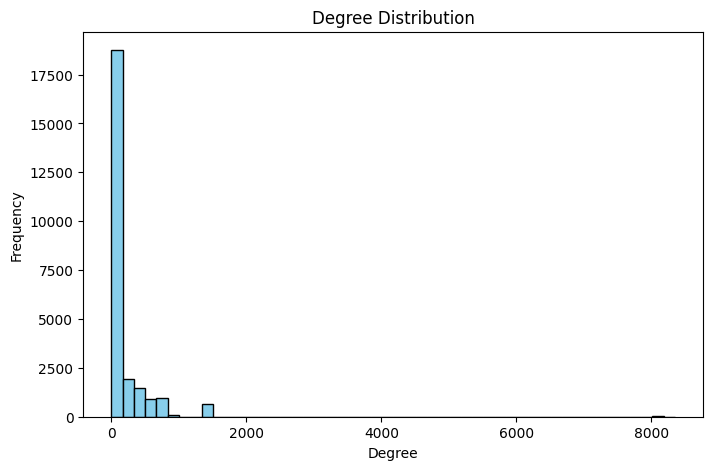

In [ ]:
import matplotlib.pyplot as plt

degrees = [deg for _, deg in G.degree()]

plt.figure(figsize=(8,5))
plt.hist(degrees, bins=50, color='skyblue', edgecolor='black')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()


**Degree Distribution(Log-log plot)**

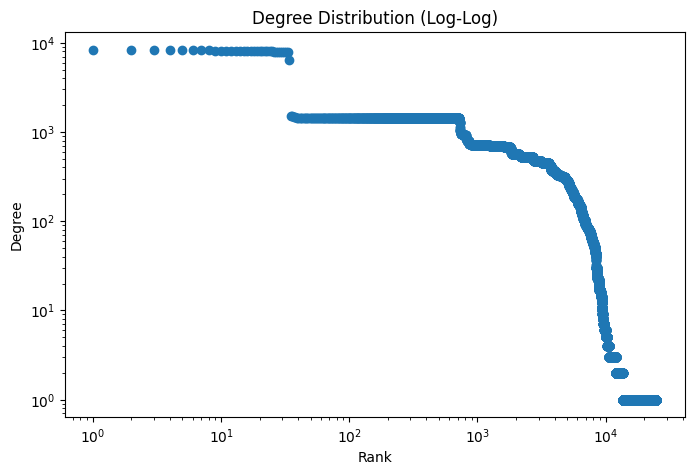

In [ ]:
plt.figure(figsize=(8,5))
plt.loglog(sorted(degrees, reverse=True), marker='o', linestyle='none')
plt.title("Degree Distribution (Log-Log)")
plt.xlabel("Rank")
plt.ylabel("Degree")
plt.show()


**Clustering coefficient**

In [ ]:
clustering = nx.average_clustering(G.to_undirected())
print("Average clustering coefficient:", clustering)


Average clustering coefficient: 0.4021161854838609


**SCC and WCC**

In [ ]:
scc = max(nx.strongly_connected_components(G), key=len)
wcc = max(nx.weakly_connected_components(G), key=len)

print("SCC size:", len(scc))
print("WCC size:", len(wcc))


SCC size: 8381
WCC size: 24881


**Average path length & diameter**

In [ ]:
G_scc = G.subgraph(scc).copy()
G_wcc = G.subgraph(wcc).copy()

print("SCC average path length:", nx.average_shortest_path_length(G_scc))
print("SCC diameter:", nx.diameter(G_scc.to_undirected()))

# Convert WCC to undirected for path length and diameter
G_wcc_und = G_wcc.to_undirected()

print("WCC average path length:", nx.average_shortest_path_length(G_wcc_und))
print("WCC diameter:", nx.diameter(G_wcc_und))


SCC average path length: 3.0670467693290795
SCC diameter: 4
WCC average path length: 3.3141424240477924
WCC diameter: 7


**Community detection**

In [ ]:
!pip install python-louvain
import community as community_louvain

partition = community_louvain.best_partition(G.to_undirected())
num_communities = len(set(partition.values()))

print("Communities detected:", num_communities)


Communities detected: 47


**Centrality measures**

**Degree centrality**

In [ ]:
deg_cent = nx.degree_centrality(G)
sorted_deg = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)

print("Top 10 degree centrality:")
for node, score in sorted_deg[:10]:
    print(node, score)

print("\nLeast 10 degree centrality:")
for node, score in sorted_deg[-10:]:
    print(node, score)


Top 10 degree centrality:
https://ontariotechu.ca 0.33677652733118973
https://ontariotechu.ca/sites/library/ 0.3357717041800643
https://ontariotechu.ca/future-students/undergraduate/campus-tours-and-events/index.php 0.335048231511254
https://ontariotechu.ca/campus-services/service-disruptions/emergency-information.php 0.3346864951768489
https://ontariotechu.ca/current-students/academic-calendars/index.php 0.33436495176848874
https://ontariotechu.ca/bookstore 0.3343247588424437
https://ontariotechu.ca/apply 0.3342443729903537
https://ontariotechu.ca/current-students/index.php 0.3297025723472669
https://ontariotechu.ca/about/ 0.3293006430868167
https://ontariotechu.ca/contact-us.php 0.3291800643086817

Least 10 degree centrality:
https://ontariotechu.ca/experts/index.php?expertise=Finite element modelling 4.019292604501608e-05
https://ontariotechu.ca/experts/index.php?expertise=Machining 4.019292604501608e-05
http://ace.ontariotechu.ca/about_ace/media-kit/project-arrow.php 4.019292604501

**Closeness**

In [ ]:
# Compute closeness
clo_cent = nx.closeness_centrality(G)

# Sort closeness values
sorted_clo = sorted(clo_cent.items(), key=lambda x: x[1], reverse=True)

# Print results
print("Top 10 closeness centrality:")
for node, score in sorted_clo[:10]:
    print(node, score)

print("\nLeast 10 closeness centrality:")
for node, score in sorted_clo[-10:]:
    print(node, score)


Top 10 closeness centrality:
https://ontariotechu.ca/sites/library/ 0.3303133254413974
https://ontariotechu.ca 0.32487638418572584
https://accessibility.ontariotechu.ca 0.3239376521463542
https://ontariotechu.ca/future-students/undergraduate/campus-tours-and-events/index.php 0.32386278788655615
https://ontariotechu.ca/current-students/academic-calendars/index.php 0.3231905634652049
https://ontariotechu.ca/bookstore 0.3231905634652049
https://itsc.ontariotechu.ca 0.3231905634652049
https://ontariotechu.ca/apply 0.3231905634652049
https://accessibility.ontariotechu.ca/essential-accessibility/index.php 0.3231905634652049
https://ontariotechu.ca/canvas/catalog-login/ 0.3231160440823446

Least 10 closeness centrality:
http://uoit.ca/special-considerations/index.php 0.06754644810703864
http://uoit.ca/faqs/index.php 0.06754644810703864
https://uoit.ca/about/campus-buildings/north-oshawa/${url} 0.06329172184738953
https://uoit.ca/virtualtour/index.php 0.06066872047667989
https://uoit.ca/curren

**Betweenness**

In [ ]:
# Compute betweenness
bet_cent = nx.betweenness_centrality(G, k=500)

# Sort betweenness values
sorted_bet = sorted(bet_cent.items(), key=lambda x: x[1], reverse=True)

# Print results
print("Top 10 betweenness centrality:")
for node, score in sorted_bet[:10]:
    print(node, score)

print("\nLeast 10 betweenness centrality:")
for node, score in sorted_bet[-10:]:
    print(node, score)


Top 10 betweenness centrality:
https://news.ontariotechu.ca/media-inquiries/index.php 0.03316184904454865
https://news.ontariotechu.ca/archives/index.php 0.03111219302193588
https://ontariotechu.ca/current-students/index.php 0.019811061682171158
https://ontariotechu.ca/current-students/academic-calendars/index.php 0.018299303789515792
https://studentlife.ontariotechu.ca/employers/index.php 0.0164872011498891
https://ontariotechu.ca/sites/library/ 0.016072711366057226
https://secretariat.ontariotechu.ca/ 0.011638986370462874
https://ontariotechu.ca/terms-of-use.php 0.011269890559679037
https://hr.ontariotechu.ca/working_at_uoit/careers/index.php 0.01087558652856005
https://hr.ontariotechu.ca/working-at-ontario-tech/careers/index.php 0.010845658891544374

Least 10 betweenness centrality:
https://studentvoices.ontariotechu.ca/quizzes/should-you-live-on-or-off-campus.php 0.0
https://studentvoices.ontariotechu.ca/quizzes/answer-these-questions-and-well-tell-you-what-you-should-do-on-valenti

**PageRank**

In [ ]:
# Compute PageRank
pr = nx.pagerank(G)

# Sort PageRank values
sorted_pr = sorted(pr.items(), key=lambda x: x[1], reverse=True)

# Print results
print("Top 10 PageRank:")
for node, score in sorted_pr[:10]:
    print(node, score)

print("\nLeast 10 PageRank:")
for node, score in sorted_pr[-10:]:
    print(node, score)


Top 10 PageRank:
https://ontariotechu.ca/map 0.01351495500353606
https://cl.catalog.ontariotechu.ca/ 0.005810902086071789
https://ontariotechu.ca/sites/library/ 0.00561747910383133
https://forms.ontariotechu.ca/forms/online/view.php?id=1007692 0.005556772336277928
https://ontariotechu.ca/contact-us.php 0.0039962302521577816
https://hr.ontariotechu.ca/working_at_uoit/careers/index.php 0.0039962302521577816
https://ontariotechu.ca/directory 0.003975173887556959
http://servicedesk.dc-uoit.ca 0.003941262325231979
https://sts.ontariotechu.ca/adfs/portal/updatepassword 0.00392084950222967
https://ontariotechu.ca 0.0038104705015703363

Least 10 PageRank:
https://ontariotechu.ca/programs/index.php?keywords=special+education+consultant 1.6073784119854198e-05
https://ontariotechu.ca/programs/index.php?keywords=business+analytics+consultant 1.6073784119854198e-05
https://ontariotechu.ca/programs/index.php?keywords=accountant 1.6073784119854198e-05
https://ontariotechu.ca/programs/index.php?keywor

**Community Size Bar Chart**

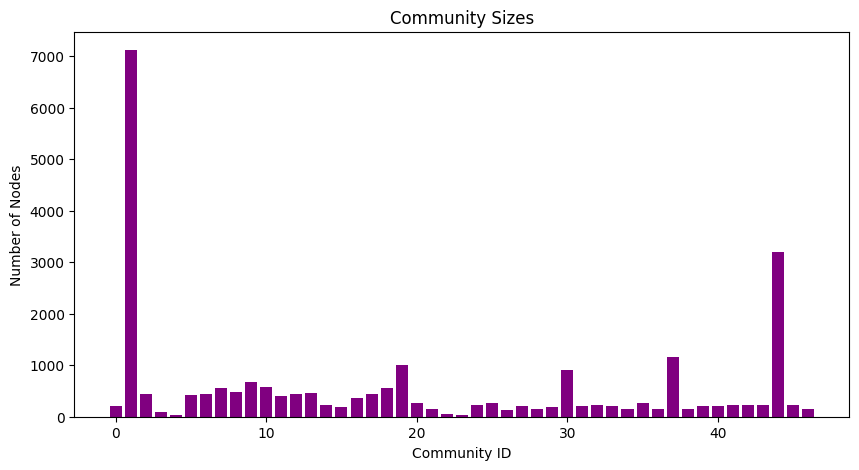

In [ ]:
import collections
import matplotlib.pyplot as plt

community_sizes = collections.Counter(partition.values())

plt.figure(figsize=(10,5))
plt.bar(community_sizes.keys(), community_sizes.values(), color='purple')
plt.title("Community Sizes")
plt.xlabel("Community ID")
plt.ylabel("Number of Nodes")
plt.show()


**Subgraph Visualization**

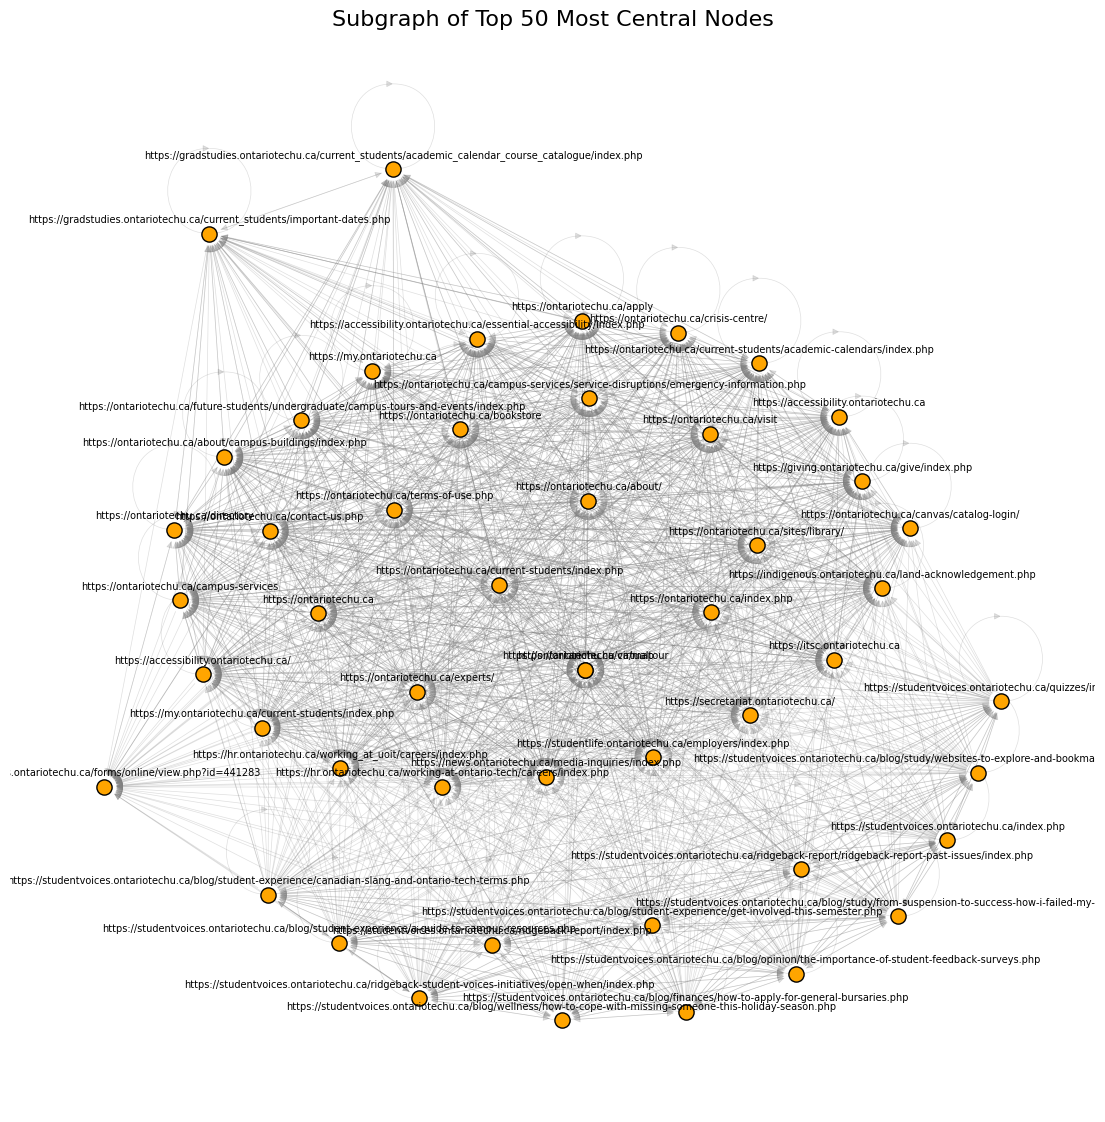

In [ ]:
# Compute top 50 by degree centrality
deg_cent = nx.degree_centrality(G)
top_nodes = sorted(deg_cent, key=deg_cent.get, reverse=True)[:50]

H = G.subgraph(top_nodes)

plt.figure(figsize=(14, 14))

# Use Kamada-Kawai layout for cleaner spacing
pos = nx.kamada_kawai_layout(H)

# Draw nodes
nx.draw_networkx_nodes(
    H, pos,
    node_size=120,
    node_color='orange',
    edgecolors='black'
)

# Draw edges lightly
nx.draw_networkx_edges(
    H, pos,
    alpha=0.25,
    width=0.5,
    edge_color='gray'
)

# Move labels slightly above nodes
label_pos = {node: (x, y + 0.03) for node, (x, y) in pos.items()}
nx.draw_networkx_labels(
    H, label_pos,
    font_size=7,
    font_color='black'
)

plt.title("Subgraph of Top 50 Most Central Nodes", fontsize=16)
plt.axis('off')
plt.show()
